In [1]:
from matplotlib import pyplot as plt
%matplotlib inline 
import healpy as hp
import numpy as np
import constrained_realizations as cr

In [2]:
# import Cls 

power_address = "PlanckPR2_TT_lowp_lensing_lensedCls.dat"
# full Cls from Camb
l, DlTT, DlEE, DlBB, DlTE = \
np.loadtxt(power_address, unpack=True, usecols=(0,1,2,3,4)) # Full
ClTT,ClEE, ClBB, ClTE = ((2*np.pi)/(l*(l+1)))*(DlTT,DlEE,DlBB,DlTE)
l = np.append([0,1],l)
ClTT = np.append([0,0],(ClTT))
ClEE = np.append([0,0],(ClEE))
ClBB = np.append([0,0],(ClBB))
ClTE = np.append([0,0],(ClTE))

ClBB = np.zeros(len(ClEE))

In [3]:
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)
LMAX = np.int0(0.8*(3*NSIDE - 1))
badval = -1.6375e+30

In [4]:
# read Planck's smica map
T_smica = hp.read_map('smica_128_bl_deconv_pl_conv.fits',verbose=False)
# get the alms from the map and deconvolve pixwin function
pl = hp.pixwin(NSIDE)
alm_T_smica = hp.almxfl(hp.map2alm(T_smica,lmax=LMAX),1/pl)

In [5]:
alm_T = np.copy(alm_T_smica)# now I'm going to define a function that will output the Q and U maps from alm_T 
# we don't want B-modes so let's set alm_B to zero
alm_B = np.zeros(len(alm_T),dtype=complex)
# now we define the function to output the maps
def gen_pol_map():
    # first get alm_E from alm_T using the constrained realizations module
    alm_E = cr.constrained_alm(alm_T,ClTT,ClEE,ClTE)
    # then we get the maps using alm2map
    # the input alms are (order matters, see alm2map documentation):
    input_alms = [alm_T,alm_E,alm_B]
    T,Q,U = hp.alm2map(input_alms,NSIDE,lmax=LMAX,pixwin=True,pol=True,verbose=False)
    # T is just the smica map back
    # Q, U are maps constrained by T
    # we will return only Q and U
    return Q,U

In [6]:
#reading the mask for the map
mask_256 = hp.read_map('mask_common_256_ecliptic.fits', nest = None, verbose = False)
#degrading the mask
mask_128 = hp.ud_grade(mask_256,128)
#modifying the degraded map
mask_128[mask_128>=0.9]=1
mask_128[mask_128<0.9]=0

#selecting the trusted pixels
goodpix = mask_128==1

#NSIDE to NPIX
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)#useful for generating the north and south sides

#generating a mask for the north
mask_north = np.copy(mask_128) #making a copy of the 128 mask
mask_north[NPIX//2:]=0 #setting the southern hemisphere to zero, this gives the map of just the north 
mask_gn = mask_north==1 #we only want pixels we can trust, this mask only has good pixels from the north

#generating a mask of the south
mask_south = np.copy(mask_128)
mask_south[:NPIX//2]=0
mask_gs = mask_south==1

In [7]:
#declaring variables 
val = 10000
#making a list for the variance
var_list_c=[None]*val
var_list_uc=[None]*val

In [ ]:
#unconstrained
for i in range(0,15):
    for x in range(0,val):
        alm_T = hp.synalm(ClTT,lmax=LMAX,verbose=False)
        T = hp.alm2map(alm_T,NSIDE,lmax=LMAX, pixwin = True, verbose = False)
        Q,U = gen_pol_map()
        gQ = np.var(Q[goodpix])
        nQ = np.var(Q[mask_gn])
        sQ = np.var(Q[mask_gs])
        gU = np.var(U[goodpix])
        nU = np.var(U[mask_gn])
        sU = np.var(U[mask_gs])
        gP = gQ + gU
        nP = nQ + nU
        sP = sQ + sU
        TQ = T*Q
        gTQ = np.var(TQ[goodpix])
        nTQ = np.var(TQ[mask_gn])
        sTQ = np.var(TQ[mask_gs])
        var_list_uc[x] = nP,sP,gP, nTQ, sTQ, gTQ
        CRvar_pol_unconfin = np.array(var_list_uc)
    fileuc = open('CRvar_pol_unconfin.dat','ab')
    np.savetxt(fileuc,CRvar_pol_unconfin)
    fileuc.close()

In [ ]:
#constrained
alm_T = np.copy(alm_T_smica)
for i in range(0,1):
    for x in range(0,val):
        Q,U = gen_pol_map()
        gQ = np.var(Q[goodpix])
        nQ = np.var(Q[mask_gn])
        sQ = np.var(Q[mask_gs])
        gU = np.var(U[goodpix])
        nU = np.var(U[mask_gn])
        sU = np.var(U[mask_gs])
        gP = gQ + gU
        nP = nQ + nU
        sP = sQ + sU
        TQ = T_smica*Q
        gTQ = np.var(TQ[goodpix])
        nTQ = np.var(TQ[mask_gn])
        sTQ = np.var(TQ[mask_gs])
        var_list_c[x] = nP,sP,gP, nTQ, sTQ, gTQ
        CRvar_pol_confin = np.array(var_list_c)
    filec = open('CRvar_pol_confin.dat','ab')
    np.savetxt(filec,CRvar_pol_confin)
    filec.close()

In [9]:
var_c = np.loadtxt('CRvar_pol_confin.dat')
var_c.shape

(151000, 6)

In [10]:
var_uc = np.loadtxt('CRvar_pol_unconfin.dat')
var_uc.shape

(151000, 6)

In [11]:
plotlabels = [r'$\langle Q^2 \rangle + \langle U^2 \rangle-North \quad(\mu K^2)$',\
              r'$\langle Q^2 \rangle + \langle U^2 \rangle-South \quad(\mu K^2)$',\
              r'$\langle Q^2 \rangle + \langle U^2 \rangle \quad(\mu K^2)$',\
              r'$\langle TQ \rangle^2-North \quad(\mu K^2)$',\
              r'$ \langle TQ \rangle^2-South \quad(\mu K^2)$',\
              r'$ \langle TQ \rangle^2\quad(\mu K^2)$']
filename = ["Pol-N", "Pol-S", "Pol", "TQ-N", "TQ-S", "TQ"]

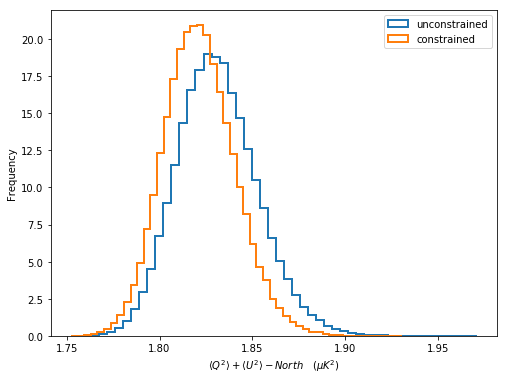

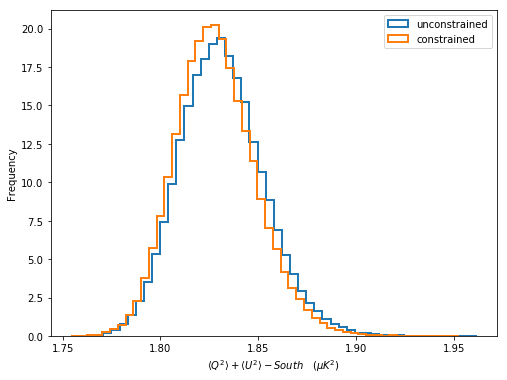

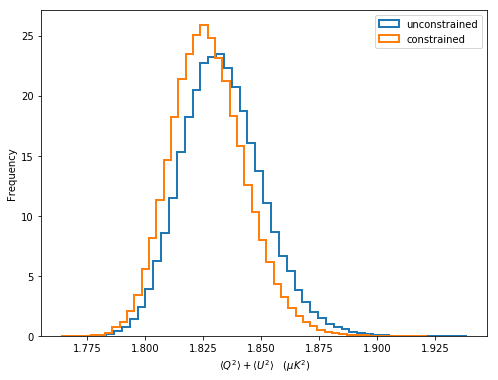

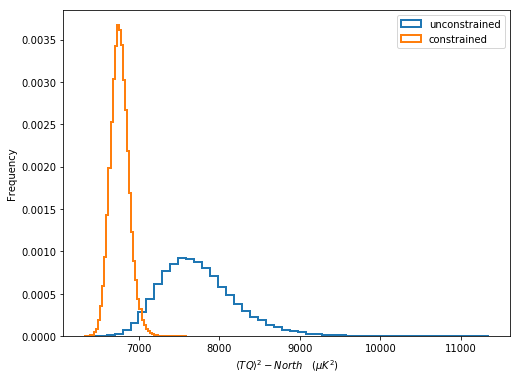

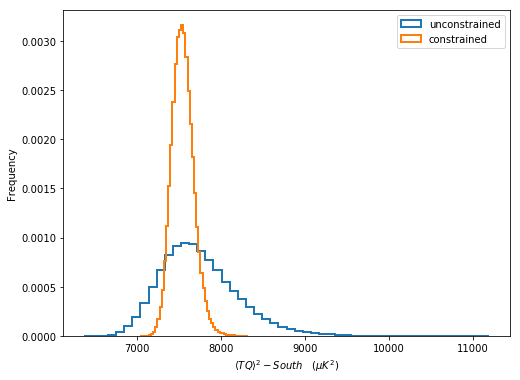

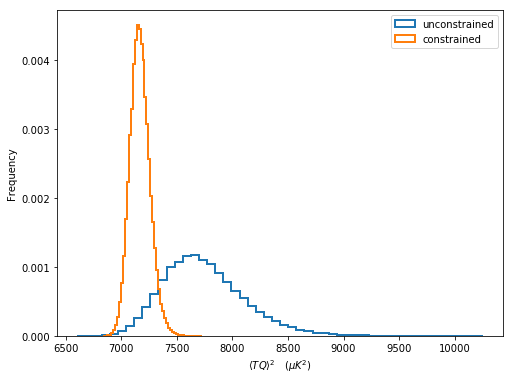

In [12]:
for i in range(0,6):
    for j in range(0,6):
        if i == j:
            fig,ax = plt.subplots(1,1,figsize=(8,6))
            ax.hist(var_uc[:,i],bins=50,histtype='step',normed=True,lw=2,label='unconstrained');
            ax.hist(var_c[:,j],bins=50,histtype='step',normed=True,lw=2,label='constrained');
            ax.set_xlabel(plotlabels[j])
            ax.set_ylabel('Frequency')
            plt.savefig('{}'.format(filename[i]),bbox_inches='tight')
            ax.legend()
            plt.show()       

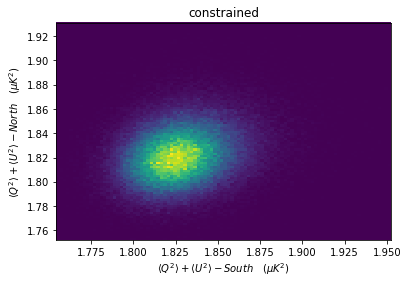

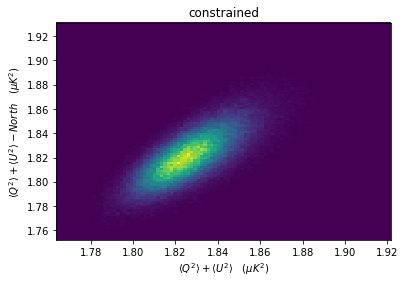

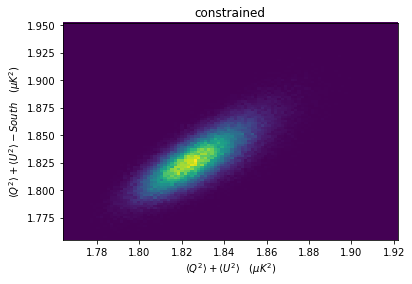

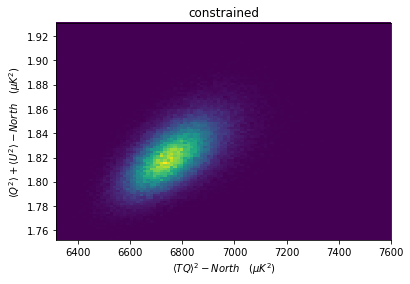

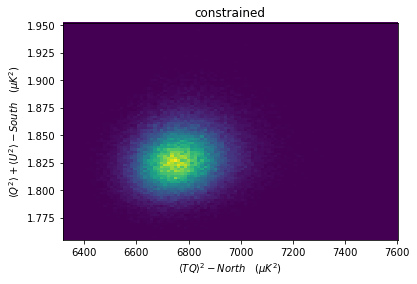

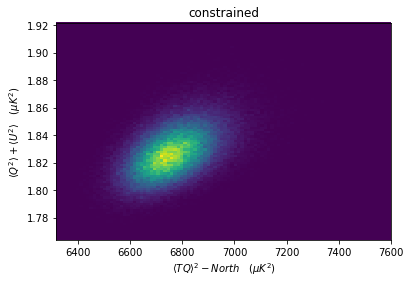

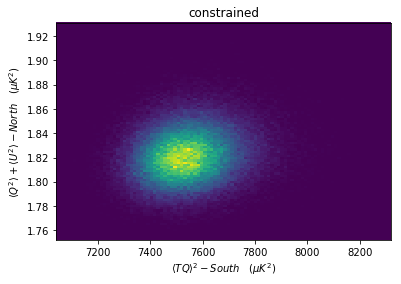

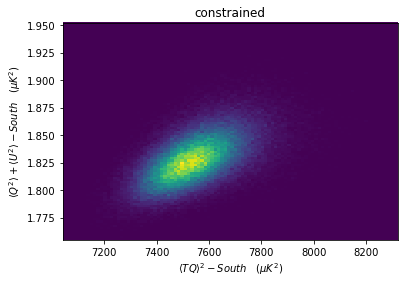

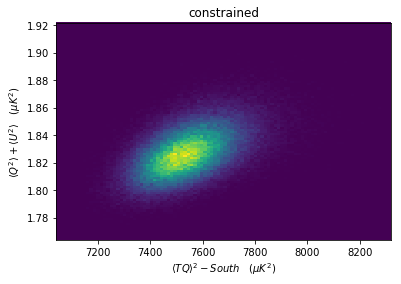

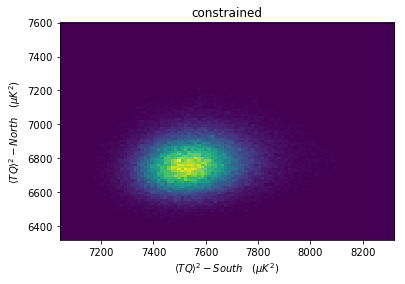

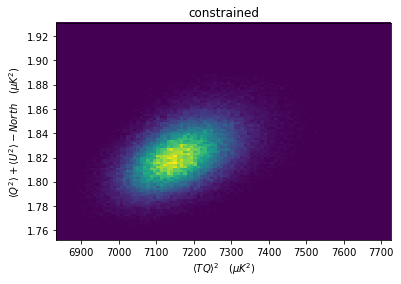

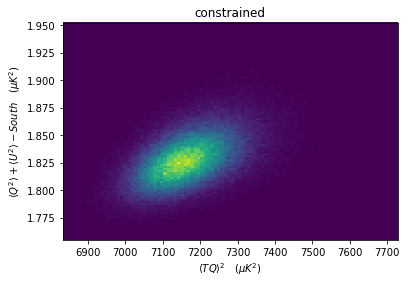

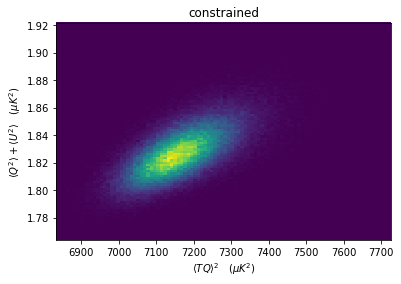

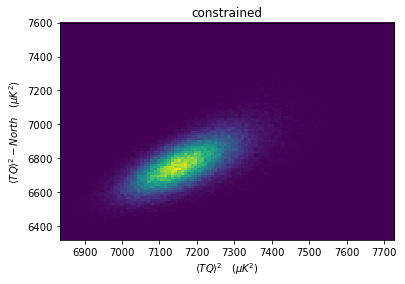

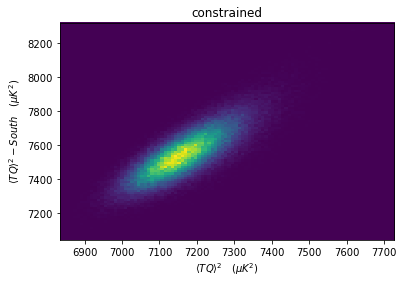

In [13]:
#constrained
for i in range(0,6):
    for j in range(i):
            plt.hist2d(var_c[:,i],var_c[:,j],bins=100)
            plt.title('constrained')
            plt.xlabel(plotlabels[i])
            plt.ylabel(plotlabels[j])
            plt.savefig("{} vs {}:Crange".format(filename[j],filename[i]),bbox_inches='tight')
            plt.show()

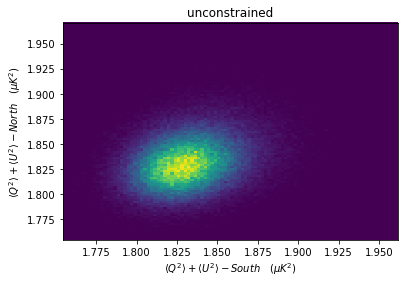

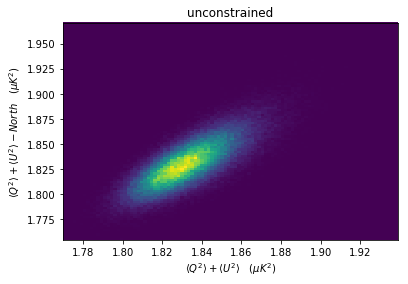

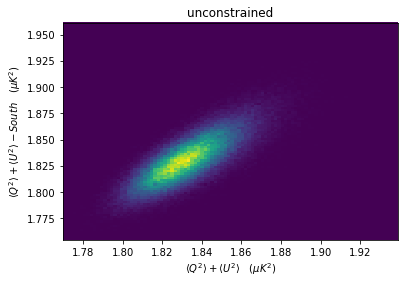

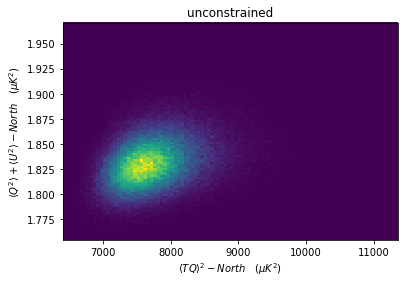

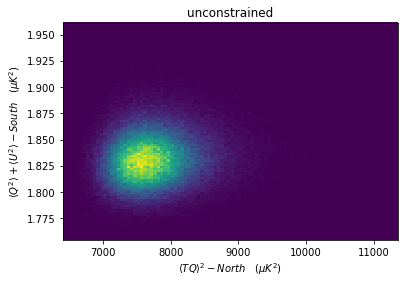

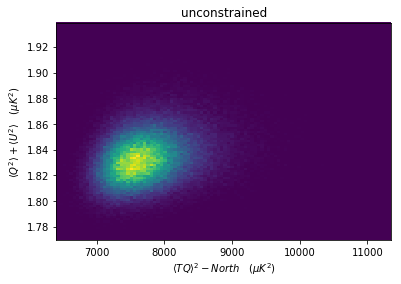

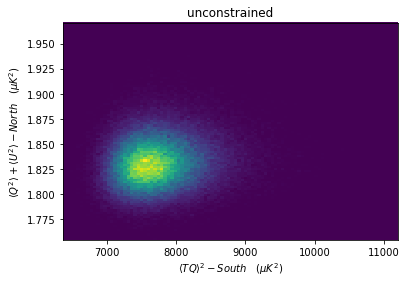

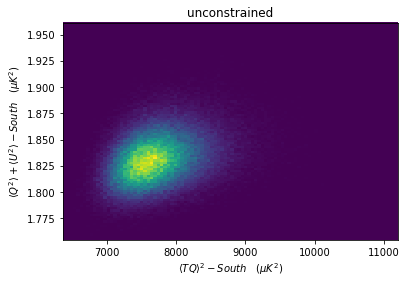

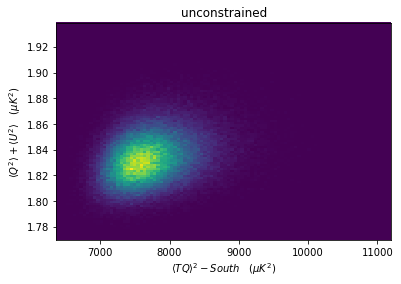

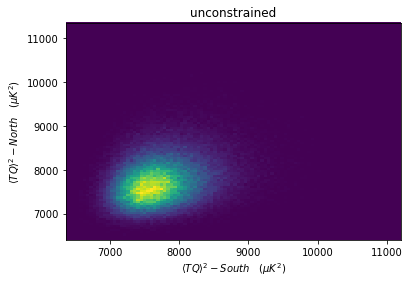

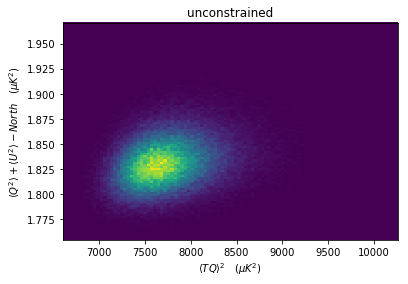

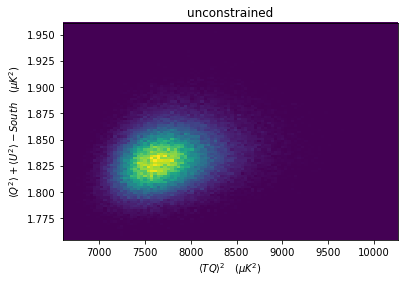

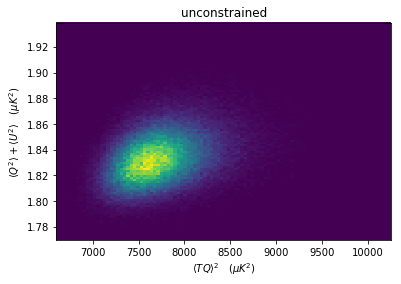

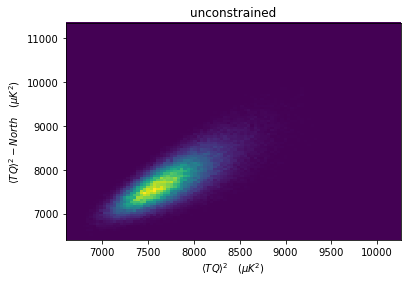

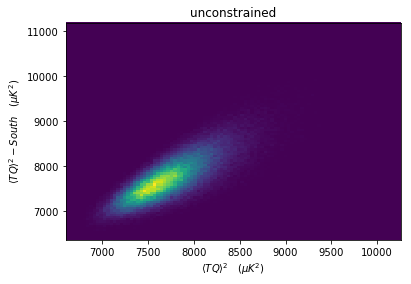

In [14]:
#unconstrained
for i in range(0,6):
    for j in range(i):
            plt.hist2d(var_uc[:,i],var_uc[:,j],100)#range = np.array([(6400,9200),(1.70,1.950)])
            plt.title('unconstrained')
            plt.xlabel(plotlabels[i])
            plt.ylabel(plotlabels[j])
            #plt.xlim(6400,9200)
            #plt.ylim(1.750,1.950)
            plt.savefig("{} vs {}:UCrange".format(filename[j],filename[i]),bbox_inches='tight')
            plt.show()

In [19]:
var_cTQ = np.delete(var_c,[0,1,2],1)
var_ucTQ = np.delete(var_uc,[0,1,2],1)
var_ucTQ.shape

(151000, 3)

In [23]:
plotlabelsTQ = [r'$\langle TQ \rangle^2-North \quad(\mu K^2)$',\
              r'$ \langle TQ \rangle^2-South \quad(\mu K^2)$',\
              r'$ \langle TQ \rangle^2\quad(\mu K^2)$']
filenameTQ = [ "TQ-N", "TQ-S", "TQ"]

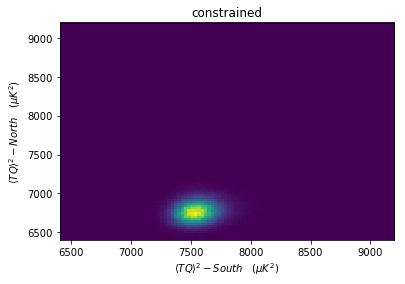

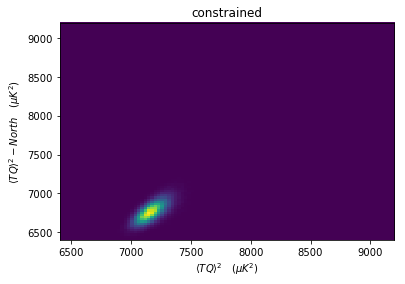

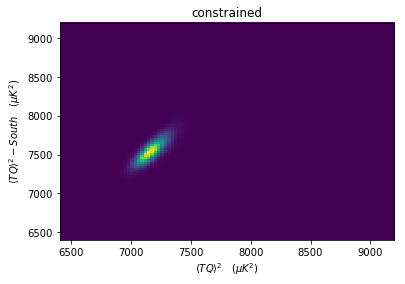

In [28]:
#TQ has different ylim
for i in range(0,3):
    for j in range(i):
            plt.hist2d(var_cTQ[:,i],var_cTQ[:,j],100,range = np.array([(6400,9200),(6400,9200)]))
            plt.title('constrained')
            plt.xlabel(plotlabelsTQ[i])
            plt.ylabel(plotlabelsTQ[j])
            plt.xlim(6400,9200)
            plt.ylim(6400,9200)
            plt.savefig("{} vs {}:TQCrange".format(filenameTQ[j],filenameTQ[i]),bbox_inches='tight')
            plt.show()

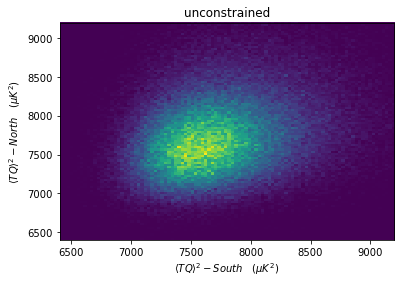

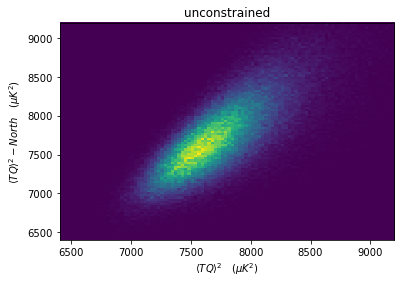

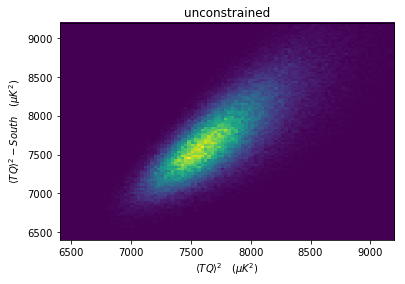

In [29]:
for i in range(0,3):
    for j in range(i):
            plt.hist2d(var_ucTQ[:,i],var_ucTQ[:,j],100,range = np.array([(6400,9200),(6400,9200)]))
            plt.title('unconstrained')
            plt.xlabel(plotlabelsTQ[i])
            plt.ylabel(plotlabelsTQ[j])
            plt.xlim(6400,9200)
            plt.ylim(6400,9200)
            plt.savefig("{} vs {}:TQUCrange".format(filenameTQ[j],filenameTQ[i]),bbox_inches='tight')
            plt.show()